In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import iplot

import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.dpi'] = 227

In [2]:
try:
  import tensorflow as tf
  from bayes_opt import BayesianOptimization
  import yfinance as yf
except:
  !pip install tensorflow bayesian-optimization yfinance
  import tensorflow as tf
  from bayes_opt import BayesianOptimization
  import yfinance as yf

In [3]:
np.random.seed(66)

try:
  data = pd.read_csv('AAPL.csv')
  data.reset_index()
except:
  from pandas_datareader import data as pdr
  yf.pdr_override()

  # download dataframe
  data = pdr.get_data_yahoo("AAPL", start="2017-01-01", end="2022-12-30")
  data.reset_index()
  data.to_csv('AAPL.csv')

[*********************100%%**********************]  1 of 1 completed


In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,26.989264,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,26.959055,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.096157,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.398233,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,27.649185,134247600


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2017-01-03 to 2022-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1509 non-null   float64
 1   High       1509 non-null   float64
 2   Low        1509 non-null   float64
 3   Close      1509 non-null   float64
 4   Adj Close  1509 non-null   float64
 5   Volume     1509 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 82.5 KB


In [6]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot, plot_components
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [7]:
Trend = data.groupby(['Date'])[['Open', 'Volume', 'Close']].sum().reset_index()
Trend.head()

,Date,Open,Volume,Close
0,2017-01-03,28.950001,115127600,29.037500
1,2017-01-04,28.962500,84472400,29.004999
2,2017-01-05,28.980000,88774400,29.152500
3,2017-01-06,29.195000,127007600,29.477501
4,2017-01-09,29.487499,134247600,29.747499


In [8]:
fig = go.Figure(go.Bar(x= Trend.Date, y= Trend.Close, name='Close'))
fig.add_trace(go.Bar(x=Trend.Date, y= Trend.Volume, name='Volume'))
fig.add_trace(go.Bar(x=Trend.Date, y= Trend.Open, name='Open'))

fig.update_layout(barmode='stack',legend_orientation="h",legend=dict(x= 0.3, y=1.1),
                 paper_bgcolor='white',
                 plot_bgcolor = "white",)
fig.show()

In [9]:
Opendf = Trend.loc[:, ['Date', 'Open']]
Opendf.tail()

,Date,Open
1504,2022-12-22,134.350006
1505,2022-12-23,130.919998
1506,2022-12-27,131.380005
1507,2022-12-28,129.669998
1508,2022-12-29,127.989998


In [10]:
Closedf = Trend.loc[:, ['Date', 'Close']]
Closedf.tail()

,Date,Close
1504,2022-12-22,132.229996
1505,2022-12-23,131.860001
1506,2022-12-27,130.029999
1507,2022-12-28,126.040001
1508,2022-12-29,129.610001


In [11]:
Volumedf = Trend.loc[:, ['Date', 'Volume']]
Volumedf.tail()

,Date,Volume
1504,2022-12-22,77852100
1505,2022-12-23,63814900
1506,2022-12-27,69007800
1507,2022-12-28,85438400
1508,2022-12-29,75703700


In [12]:
model = Prophet()

In [13]:
Opendf.columns = ['ds', 'y']
model.fit(Opendf)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq6xr3mav/8ac621lm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq6xr3mav/s87nwxco.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91206', 'data', 'file=/tmp/tmpq6xr3mav/8ac621lm.json', 'init=/tmp/tmpq6xr3mav/s87nwxco.json', 'output', 'file=/tmp/tmpq6xr3mav/prophet_modelxz2u1guz/prophet_model-20240424214515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:45:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:45:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [14]:
future = model.make_future_dataframe(periods=60) # helper function to extend the dataframe for specified days
future.tail()

,ds
1564,2023-02-23
1565,2023-02-24
1566,2023-02-25
1567,2023-02-26
1568,2023-02-27


In [15]:
pred = model.predict(future)
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-03,28.216884,24.918927,40.670764,28.216884,28.216884,4.250151,4.250151,4.250151,0.063523,0.063523,0.063523,4.186628,4.186628,4.186628,0.0,0.0,0.0,32.467034
1,2017-01-04,28.284885,24.851564,40.165300,28.284885,28.284885,4.325820,4.325820,4.325820,0.040256,0.040256,0.040256,4.285564,4.285564,4.285564,0.0,0.0,0.0,32.610705
2,2017-01-05,28.352886,24.358494,40.955072,28.352886,28.352886,4.277955,4.277955,4.277955,-0.092452,-0.092452,-0.092452,4.370407,4.370407,4.370407,0.0,0.0,0.0,32.630841
3,2017-01-06,28.420887,25.175595,40.639238,28.420887,28.420887,4.277324,4.277324,4.277324,-0.163559,-0.163559,-0.163559,4.440883,4.440883,4.440883,0.0,0.0,0.0,32.698212
4,2017-01-09,28.624891,25.527916,40.872757,28.624891,28.624891,4.313575,4.313575,4.313575,-0.255082,-0.255082,-0.255082,4.568658,4.568658,4.568658,0.0,0.0,0.0,32.938467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1564,2023-02-23,146.807748,141.983935,158.039603,145.773348,147.938084,3.095227,3.095227,3.095227,-0.092452,-0.092452,-0.092452,3.187679,3.187679,3.187679,0.0,0.0,0.0,149.902975
1565,2023-02-24,146.779054,141.678174,157.280132,145.689334,147.937527,2.662214,2.662214,2.662214,-0.163559,-0.163559,-0.163559,2.825773,2.825773,2.825773,0.0,0.0,0.0,149.441268
1566,2023-02-25,146.750361,141.586149,157.242076,145.625417,147.934045,2.661301,2.661301,2.661301,0.203657,0.203657,0.203657,2.457644,2.457644,2.457644,0.0,0.0,0.0,149.411663
1567,2023-02-26,146.721668,141.326678,156.692179,145.548610,147.952221,2.291142,2.291142,2.291142,0.203657,0.203657,0.203657,2.087485,2.087485,2.087485,0.0,0.0,0.0,149.012810


In [16]:
figure = plot_plotly(model, pred)

figure.update_layout(template='plotly_white')

iplot(figure)

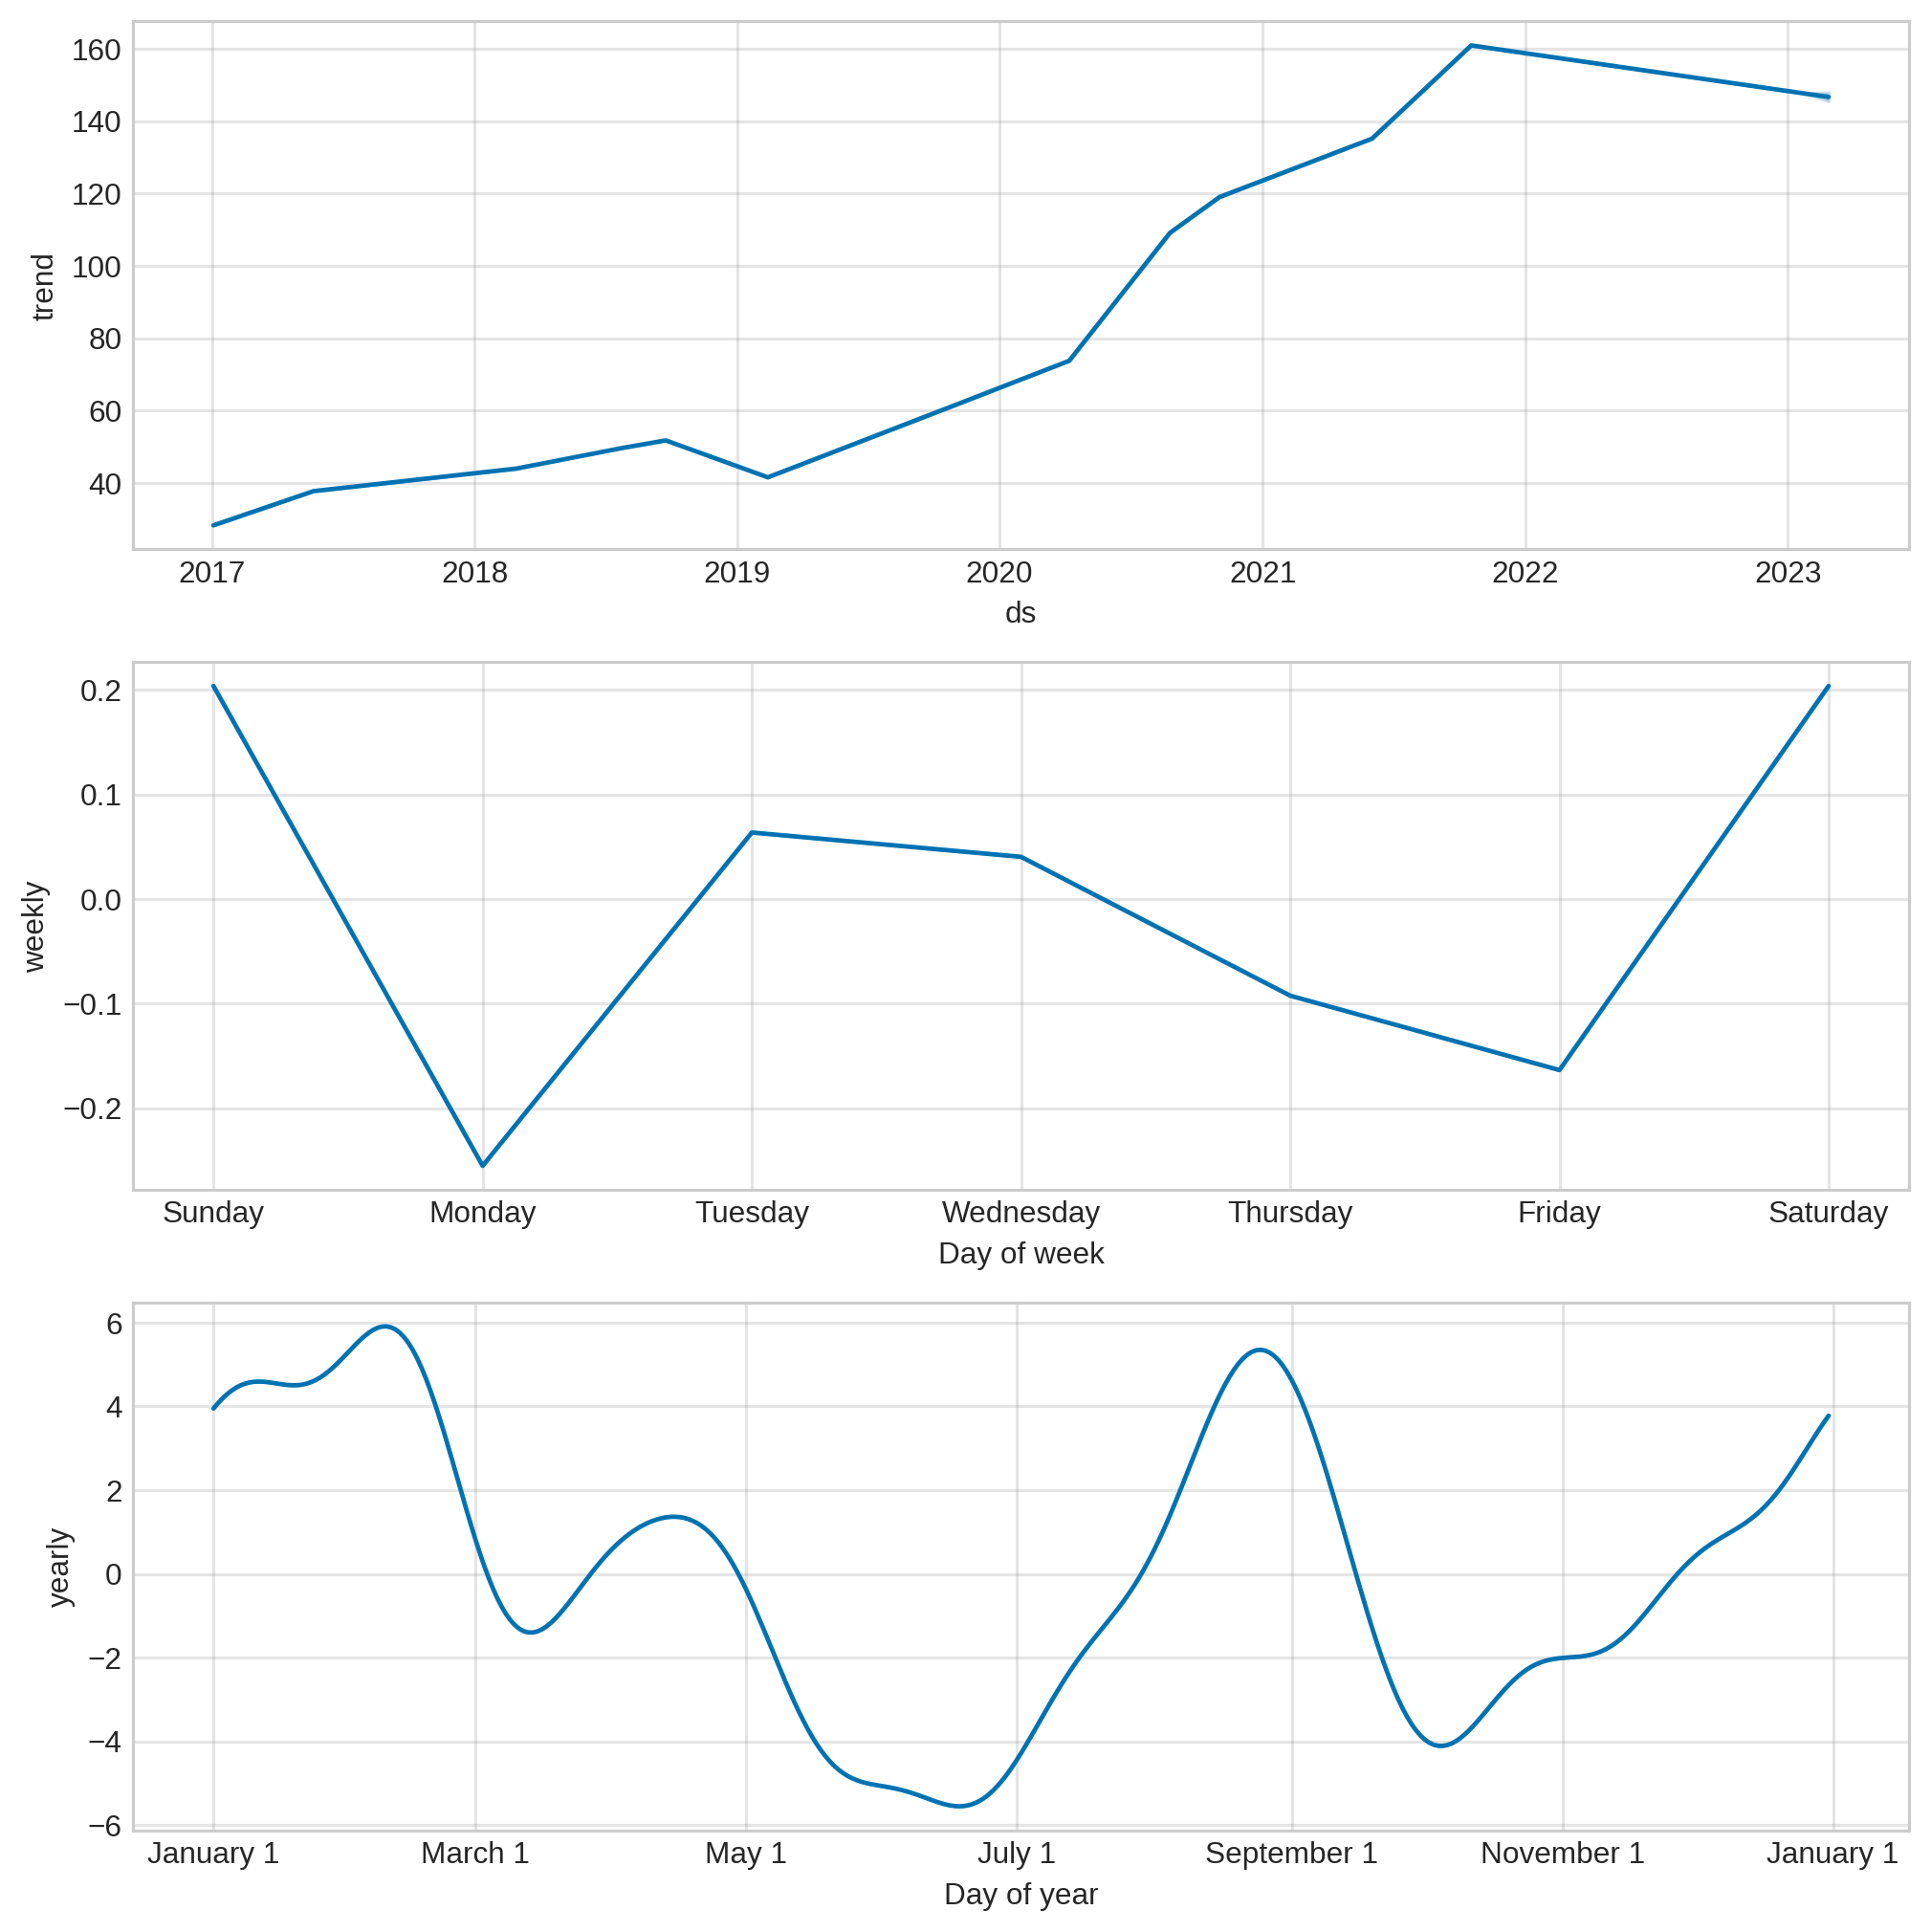

In [17]:
figure_comp = model.plot_components(pred)

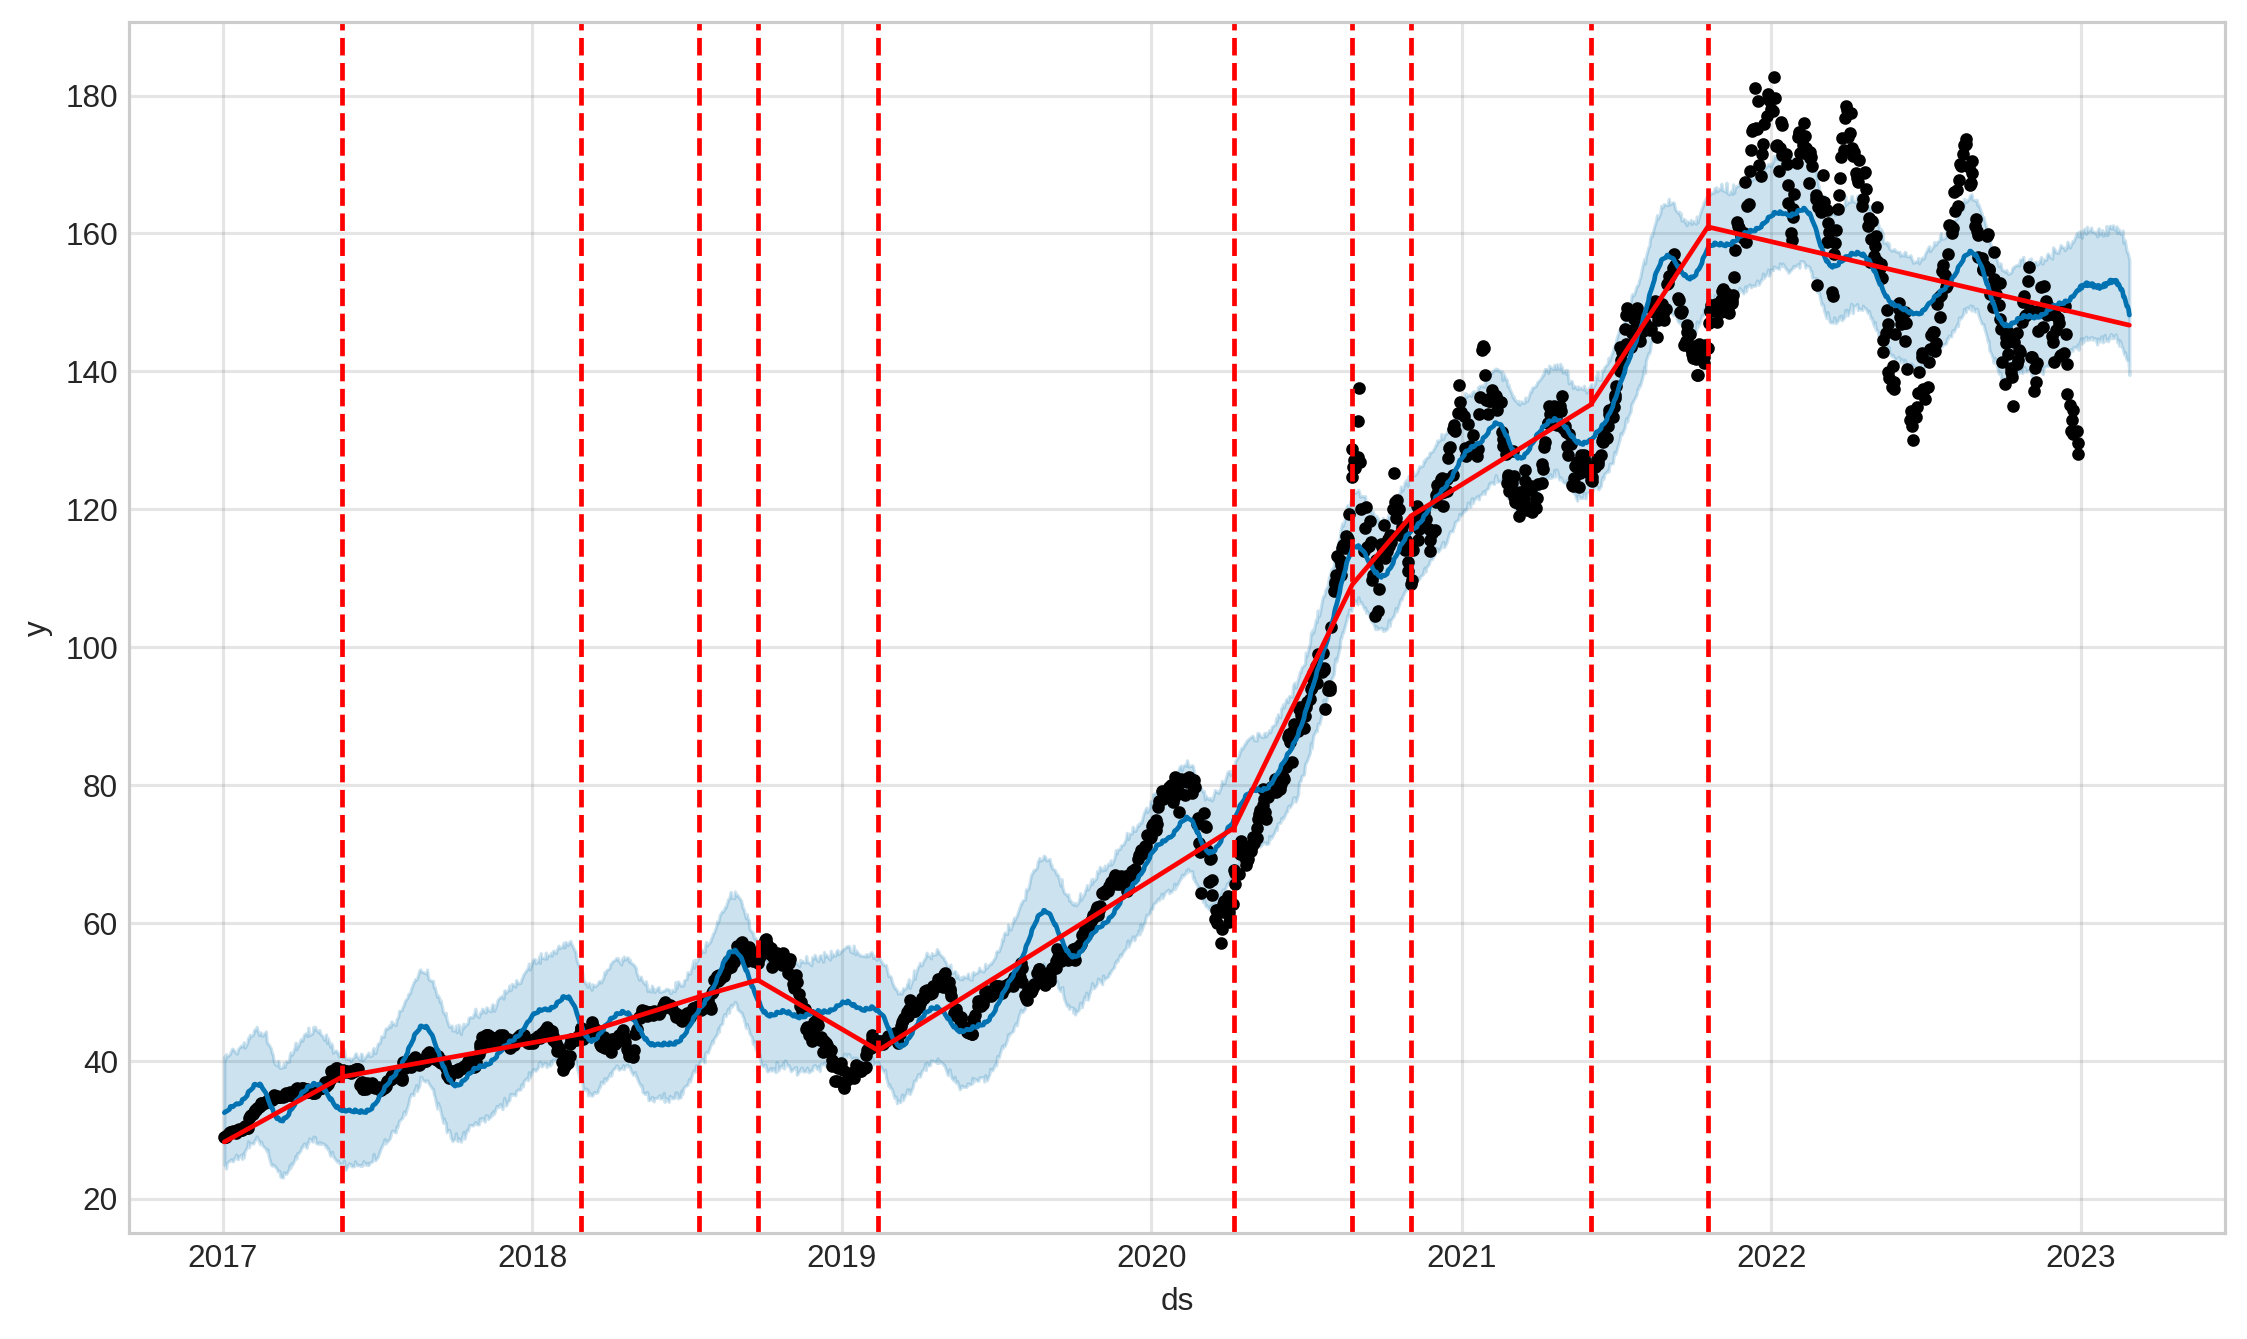

In [18]:
plot_model = model.plot(pred)
a = add_changepoints_to_plot(plot_model.gca(), model, pred)

In [19]:
model.changepoints

48     2017-03-14
96     2017-05-22
145    2017-08-01
193    2017-10-09
241    2017-12-15
289    2018-02-27
338    2018-05-08
386    2018-07-17
434    2018-09-24
482    2018-11-30
531    2019-02-13
579    2019-04-24
627    2019-07-02
675    2019-09-10
724    2019-11-18
772    2020-01-29
820    2020-04-07
868    2020-06-16
917    2020-08-25
965    2020-11-02
1013   2021-01-12
1061   2021-03-23
1110   2021-06-02
1158   2021-08-10
1206   2021-10-18
Name: ds, dtype: datetime64[ns]

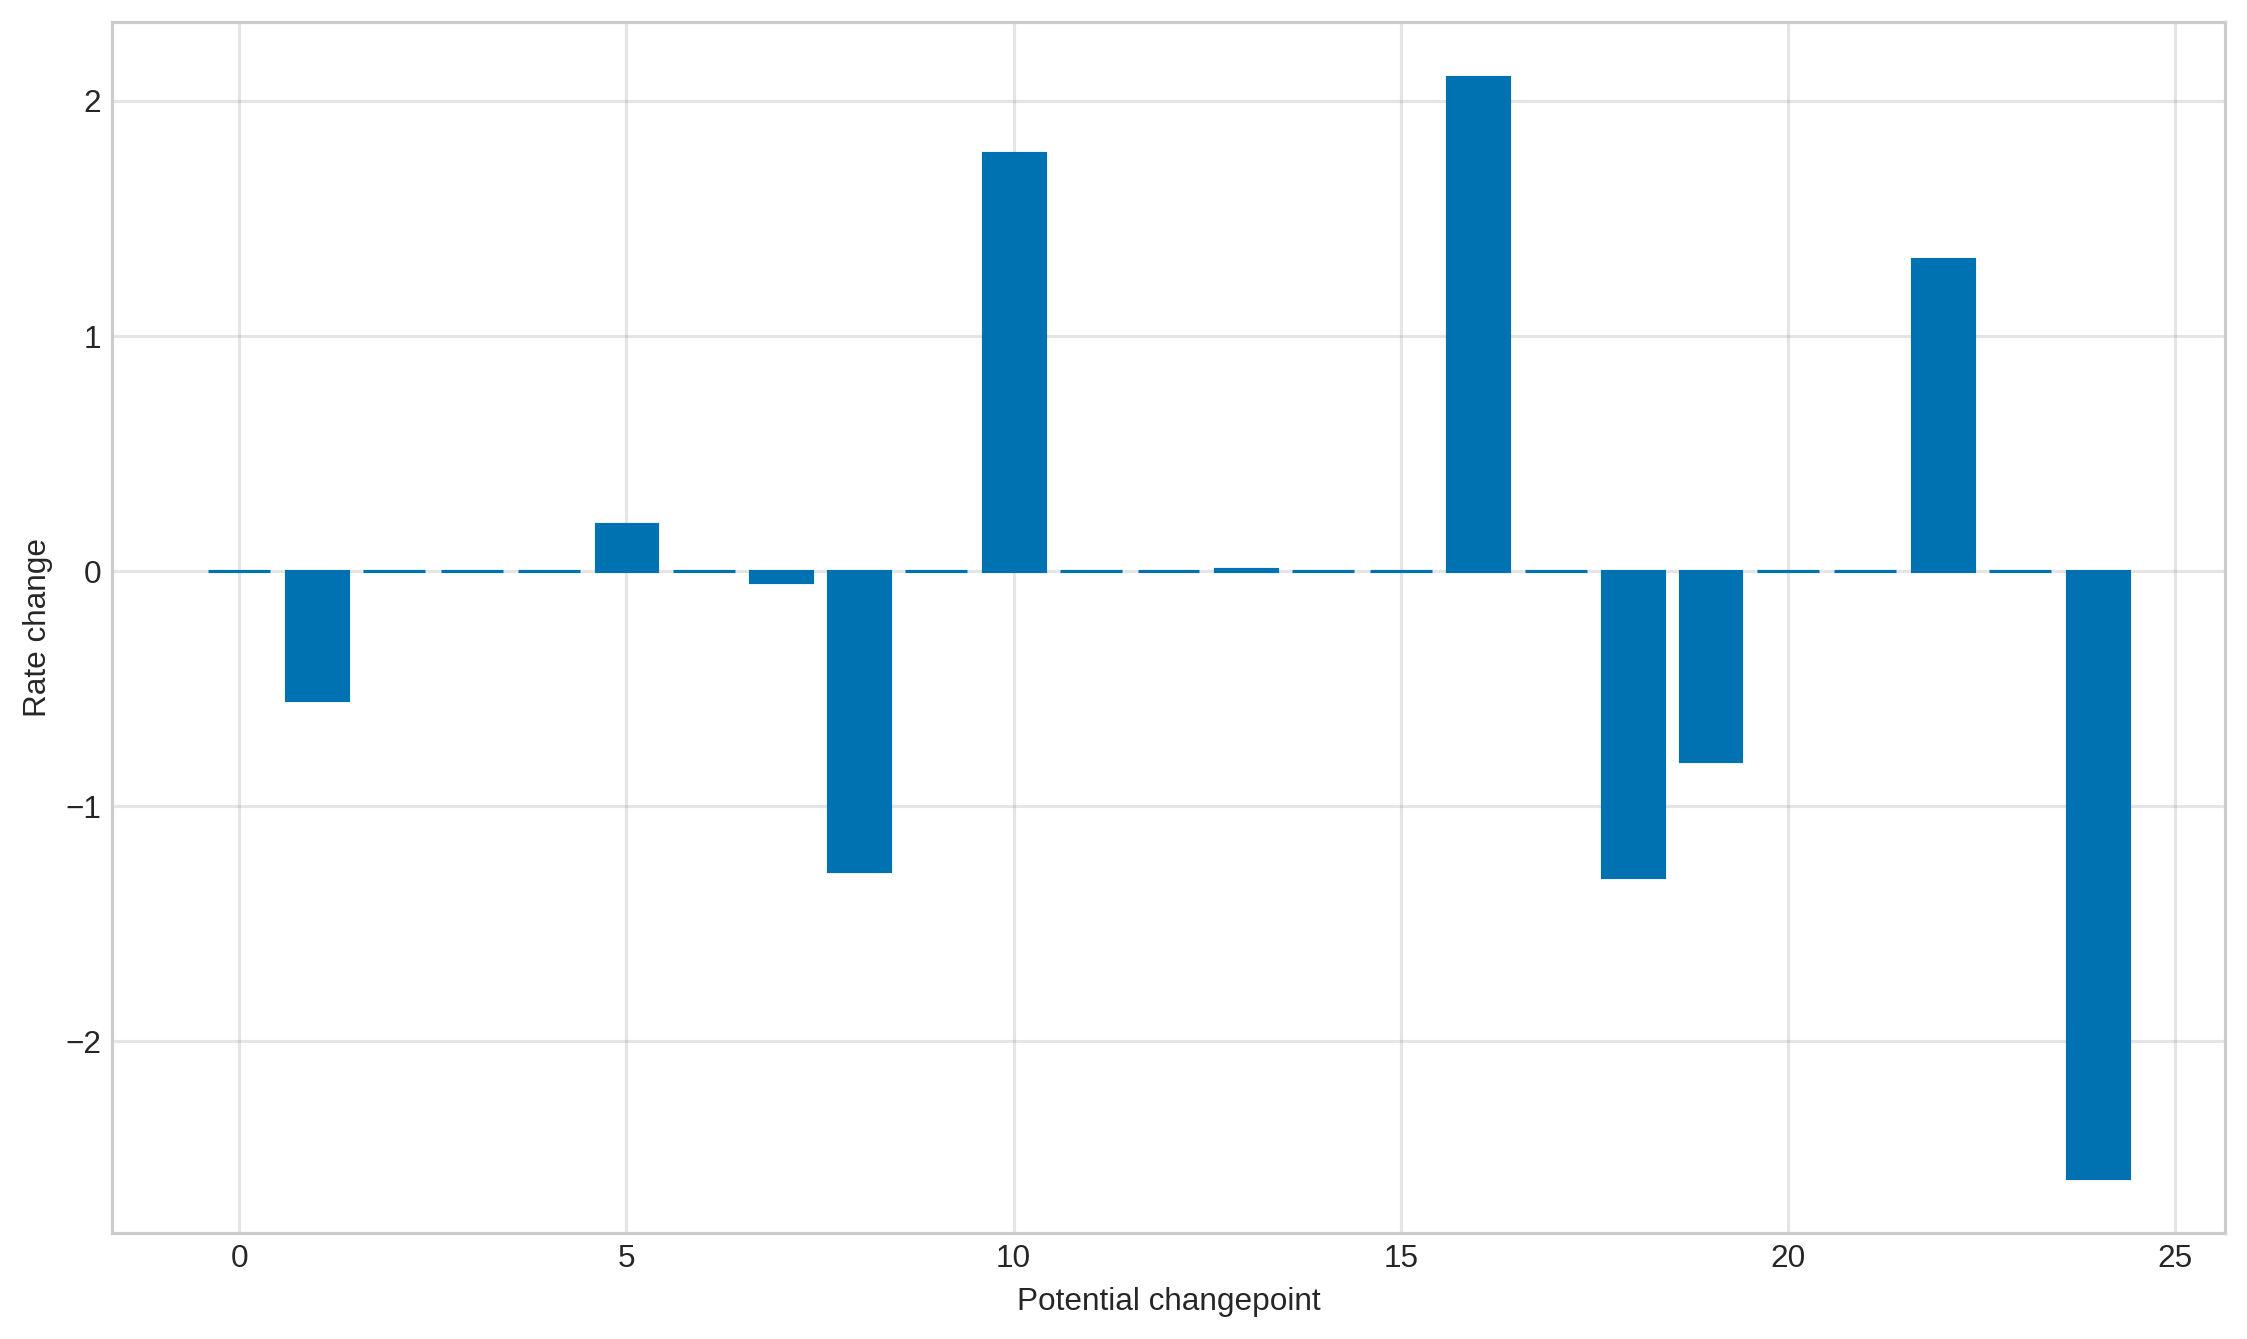

In [20]:
deltas = model.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq6xr3mav/7qof_8yd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq6xr3mav/0_j_4z1r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40570', 'data', 'file=/tmp/tmpq6xr3mav/7qof_8yd.json', 'init=/tmp/tmpq6xr3mav/0_j_4z1r.json', 'output', 'file=/tmp/tmpq6xr3mav/prophet_modelmxfqxx51/prophet_model-20240424214521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:45:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:45:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


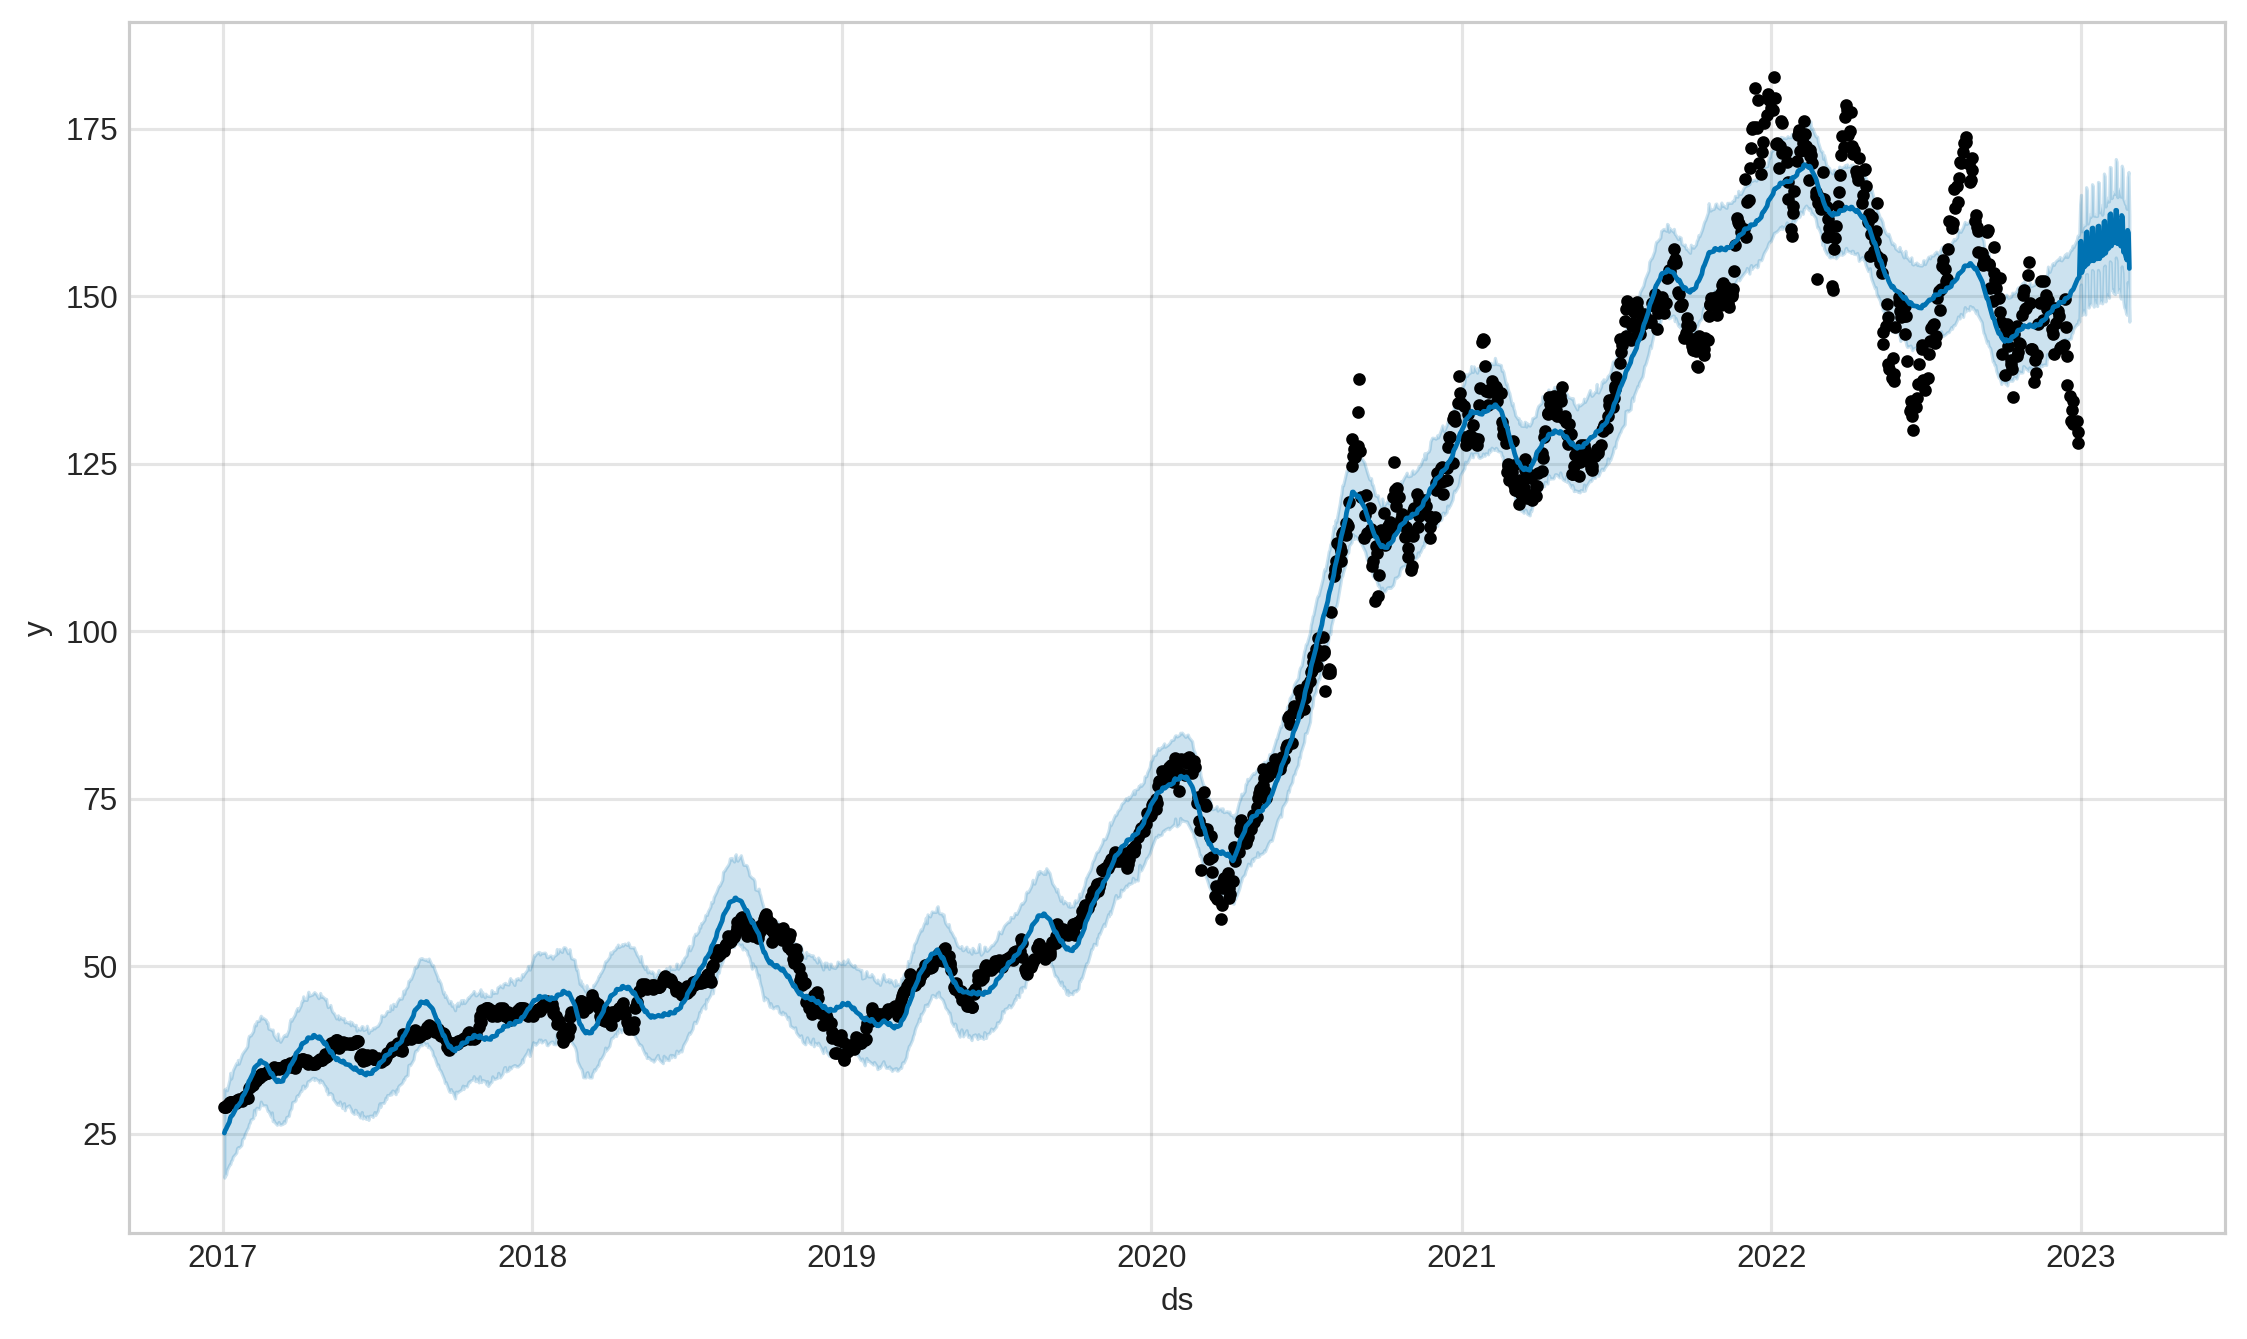

In [21]:
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(Opendf).predict(future)
Newfig = m.plot(forecast)

In [22]:
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)

print("Mean Absolute Error (MAE):", df_p['mae'].values[0])
print("Root Mean Squared Error (RMSE):", df_p['rmse'].values[0])

INFO:prophet:Making 7 forecasts with cutoffs between 2019-01-14 00:00:00 and 2021-12-29 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpq6xr3mav/3yfh4xcg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq6xr3mav/_bgvazxu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39674', 'data', 'file=/tmp/tmpq6xr3mav/3yfh4xcg.json', 'init=/tmp/tmpq6xr3mav/_bgvazxu.json', 'output', 'file=/tmp/tmpq6xr3mav/prophet_modelh4ttku4h/prophet_model-20240424214524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:45:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:45:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq6xr3mav/6lu1sw5p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq6xr3mav/ftg6z_2b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Mean Absolute Error (MAE): 6.996146029038979
Root Mean Squared Error (RMSE): 8.987921375494533


In [23]:
df_cv.head(5)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-15,37.355211,36.132937,38.519745,37.567501,2019-01-14
1,2019-01-16,37.474320,36.253764,38.619961,38.270000,2019-01-14
2,2019-01-17,37.404242,36.200763,38.505368,38.549999,2019-01-14
3,2019-01-18,37.332694,36.131556,38.448351,39.375000,2019-01-14
4,2019-01-22,36.926665,35.742773,38.107607,39.102501,2019-01-14


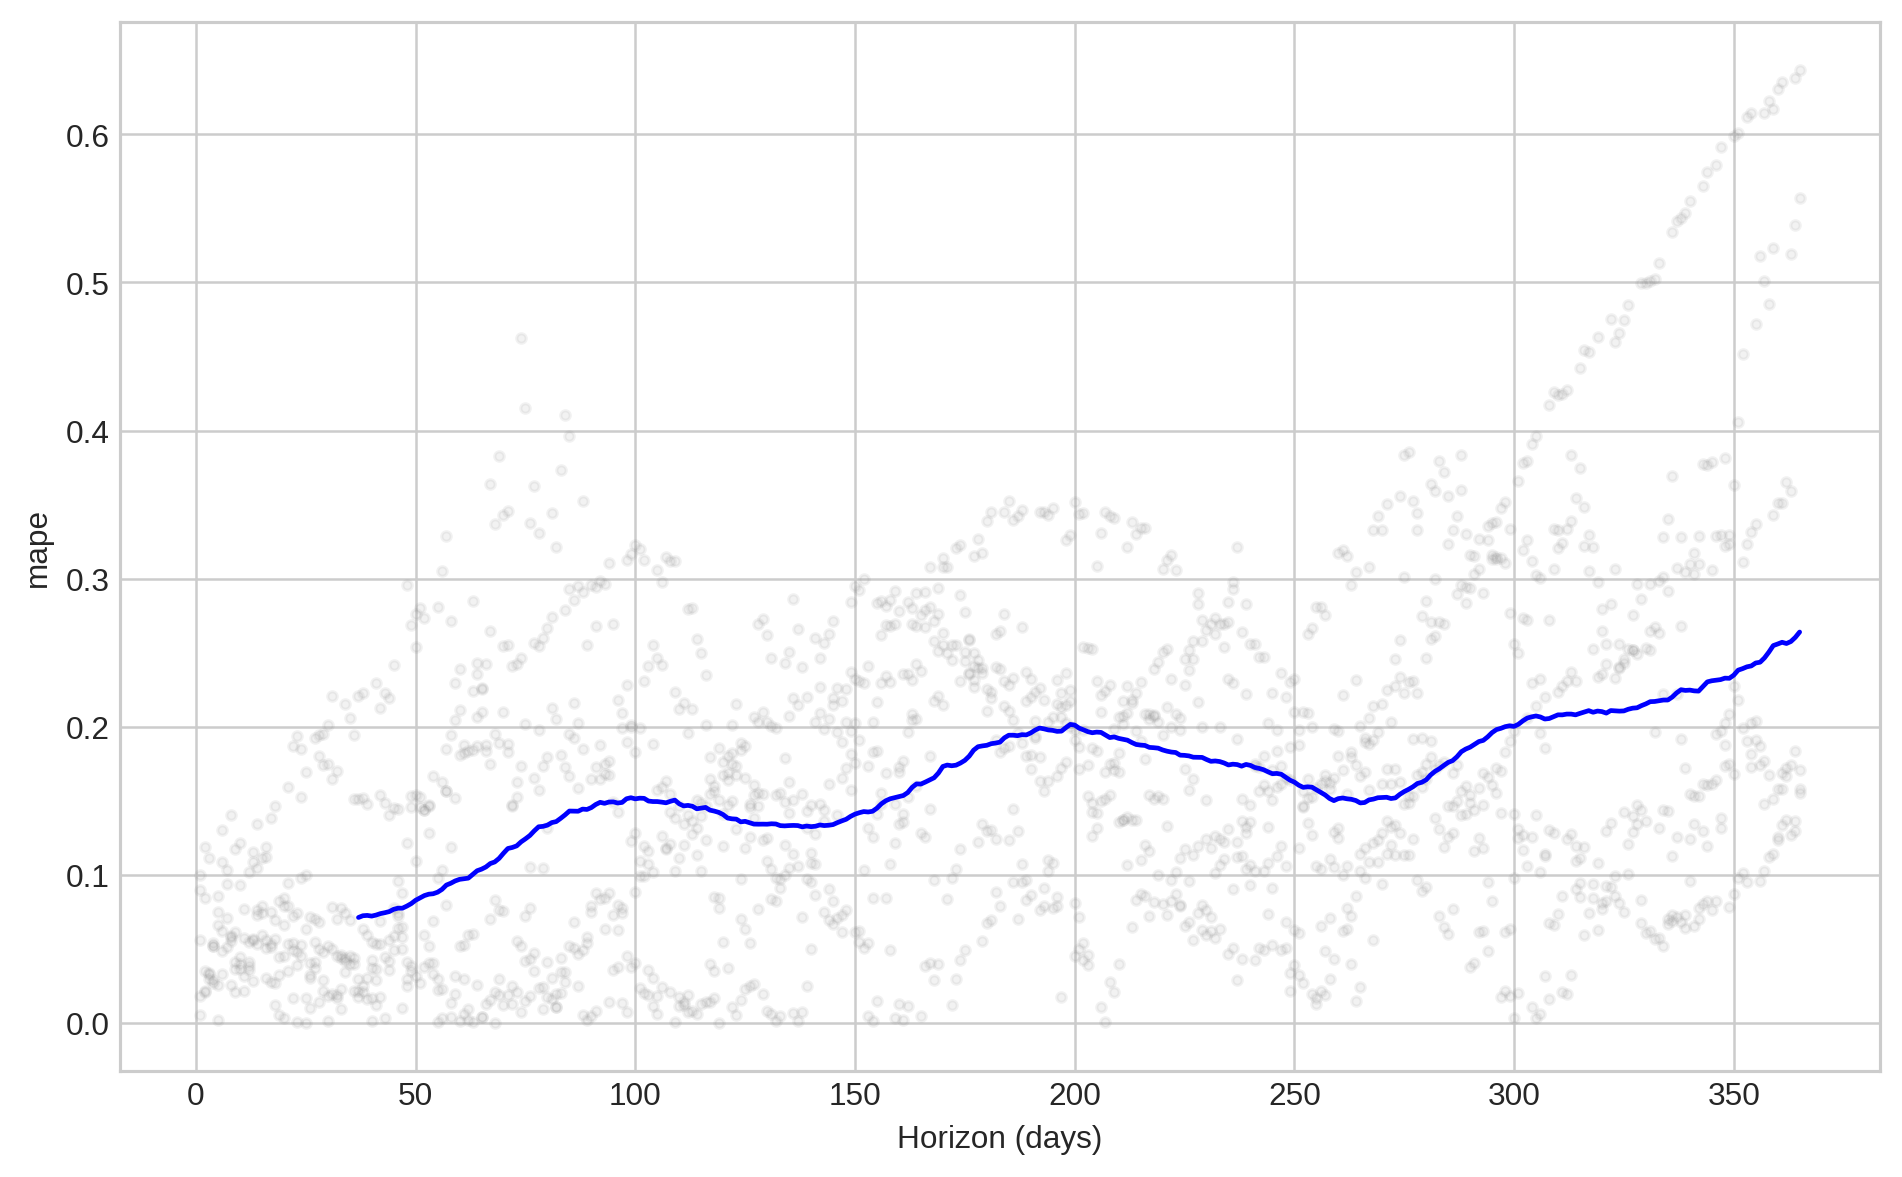

In [24]:
CV_fig = plot_cross_validation_metric(df_cv, metric='mape')

In [25]:
df_p.head(5)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,80.782731,8.987921,6.996146,0.071265,0.054005,0.075265,0.243182
1,38 days,83.197486,9.121266,7.074168,0.072443,0.054395,0.076615,0.239773
2,39 days,82.738419,9.096066,7.065272,0.072655,0.054395,0.076854,0.238636
3,40 days,82.835992,9.101428,7.071724,0.072203,0.054549,0.076375,0.237500
4,41 days,85.872902,9.266763,7.157518,0.072895,0.054549,0.077202,0.243182


In [26]:
model1 = Prophet()

In [27]:
Closedf.columns = ['ds', 'y']
model1.fit(Closedf)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq6xr3mav/tm7m5h12.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq6xr3mav/lydyrjkh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41356', 'data', 'file=/tmp/tmpq6xr3mav/tm7m5h12.json', 'init=/tmp/tmpq6xr3mav/lydyrjkh.json', 'output', 'file=/tmp/tmpq6xr3mav/prophet_modelli2btr8j/prophet_model-20240424214536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:45:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:45:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [28]:
future1 = model1.make_future_dataframe(periods=60) # helper function to extend the dataframe for specified days
future1.tail()

,ds
1564,2023-02-23
1565,2023-02-24
1566,2023-02-25
1567,2023-02-26
1568,2023-02-27


In [29]:
pred1 = model1.predict(future1)
pred1

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-03,28.876978,25.259865,40.502374,28.876978,28.876978,4.194960,4.194960,4.194960,0.106815,0.106815,0.106815,4.088145,4.088145,4.088145,0.0,0.0,0.0,33.071938
1,2017-01-04,28.936462,25.108494,41.039519,28.936462,28.936462,4.306047,4.306047,4.306047,0.117935,0.117935,0.117935,4.188112,4.188112,4.188112,0.0,0.0,0.0,33.242510
2,2017-01-05,28.995947,24.837612,41.464069,28.995947,28.995947,4.214312,4.214312,4.214312,-0.056165,-0.056165,-0.056165,4.270477,4.270477,4.270477,0.0,0.0,0.0,33.210258
3,2017-01-06,29.055431,24.838421,40.769841,29.055431,29.055431,4.190892,4.190892,4.190892,-0.144004,-0.144004,-0.144004,4.334896,4.334896,4.334896,0.0,0.0,0.0,33.246323
4,2017-01-09,29.233884,25.257782,41.652370,29.233884,29.233884,4.509183,4.509183,4.509183,0.085265,0.085265,0.085265,4.423918,4.423918,4.423918,0.0,0.0,0.0,33.743067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1564,2023-02-23,146.317700,141.071017,157.430102,145.218044,147.509033,2.773088,2.773088,2.773088,-0.056165,-0.056165,-0.056165,2.829253,2.829253,2.829253,0.0,0.0,0.0,149.090788
1565,2023-02-24,146.287262,140.463218,156.422076,145.181521,147.526846,2.307524,2.307524,2.307524,-0.144004,-0.144004,-0.144004,2.451528,2.451528,2.451528,0.0,0.0,0.0,148.594785
1566,2023-02-25,146.256824,140.430049,156.834999,145.120921,147.548118,2.014786,2.014786,2.014786,-0.054923,-0.054923,-0.054923,2.069709,2.069709,2.069709,0.0,0.0,0.0,148.271609
1567,2023-02-26,146.226386,139.931257,156.106599,145.060322,147.587824,1.633599,1.633599,1.633599,-0.054923,-0.054923,-0.054923,1.688522,1.688522,1.688522,0.0,0.0,0.0,147.859985


In [30]:
figure1 = plot_plotly(model1, pred1)

figure1.update_layout(template='plotly_white')

iplot(figure1)

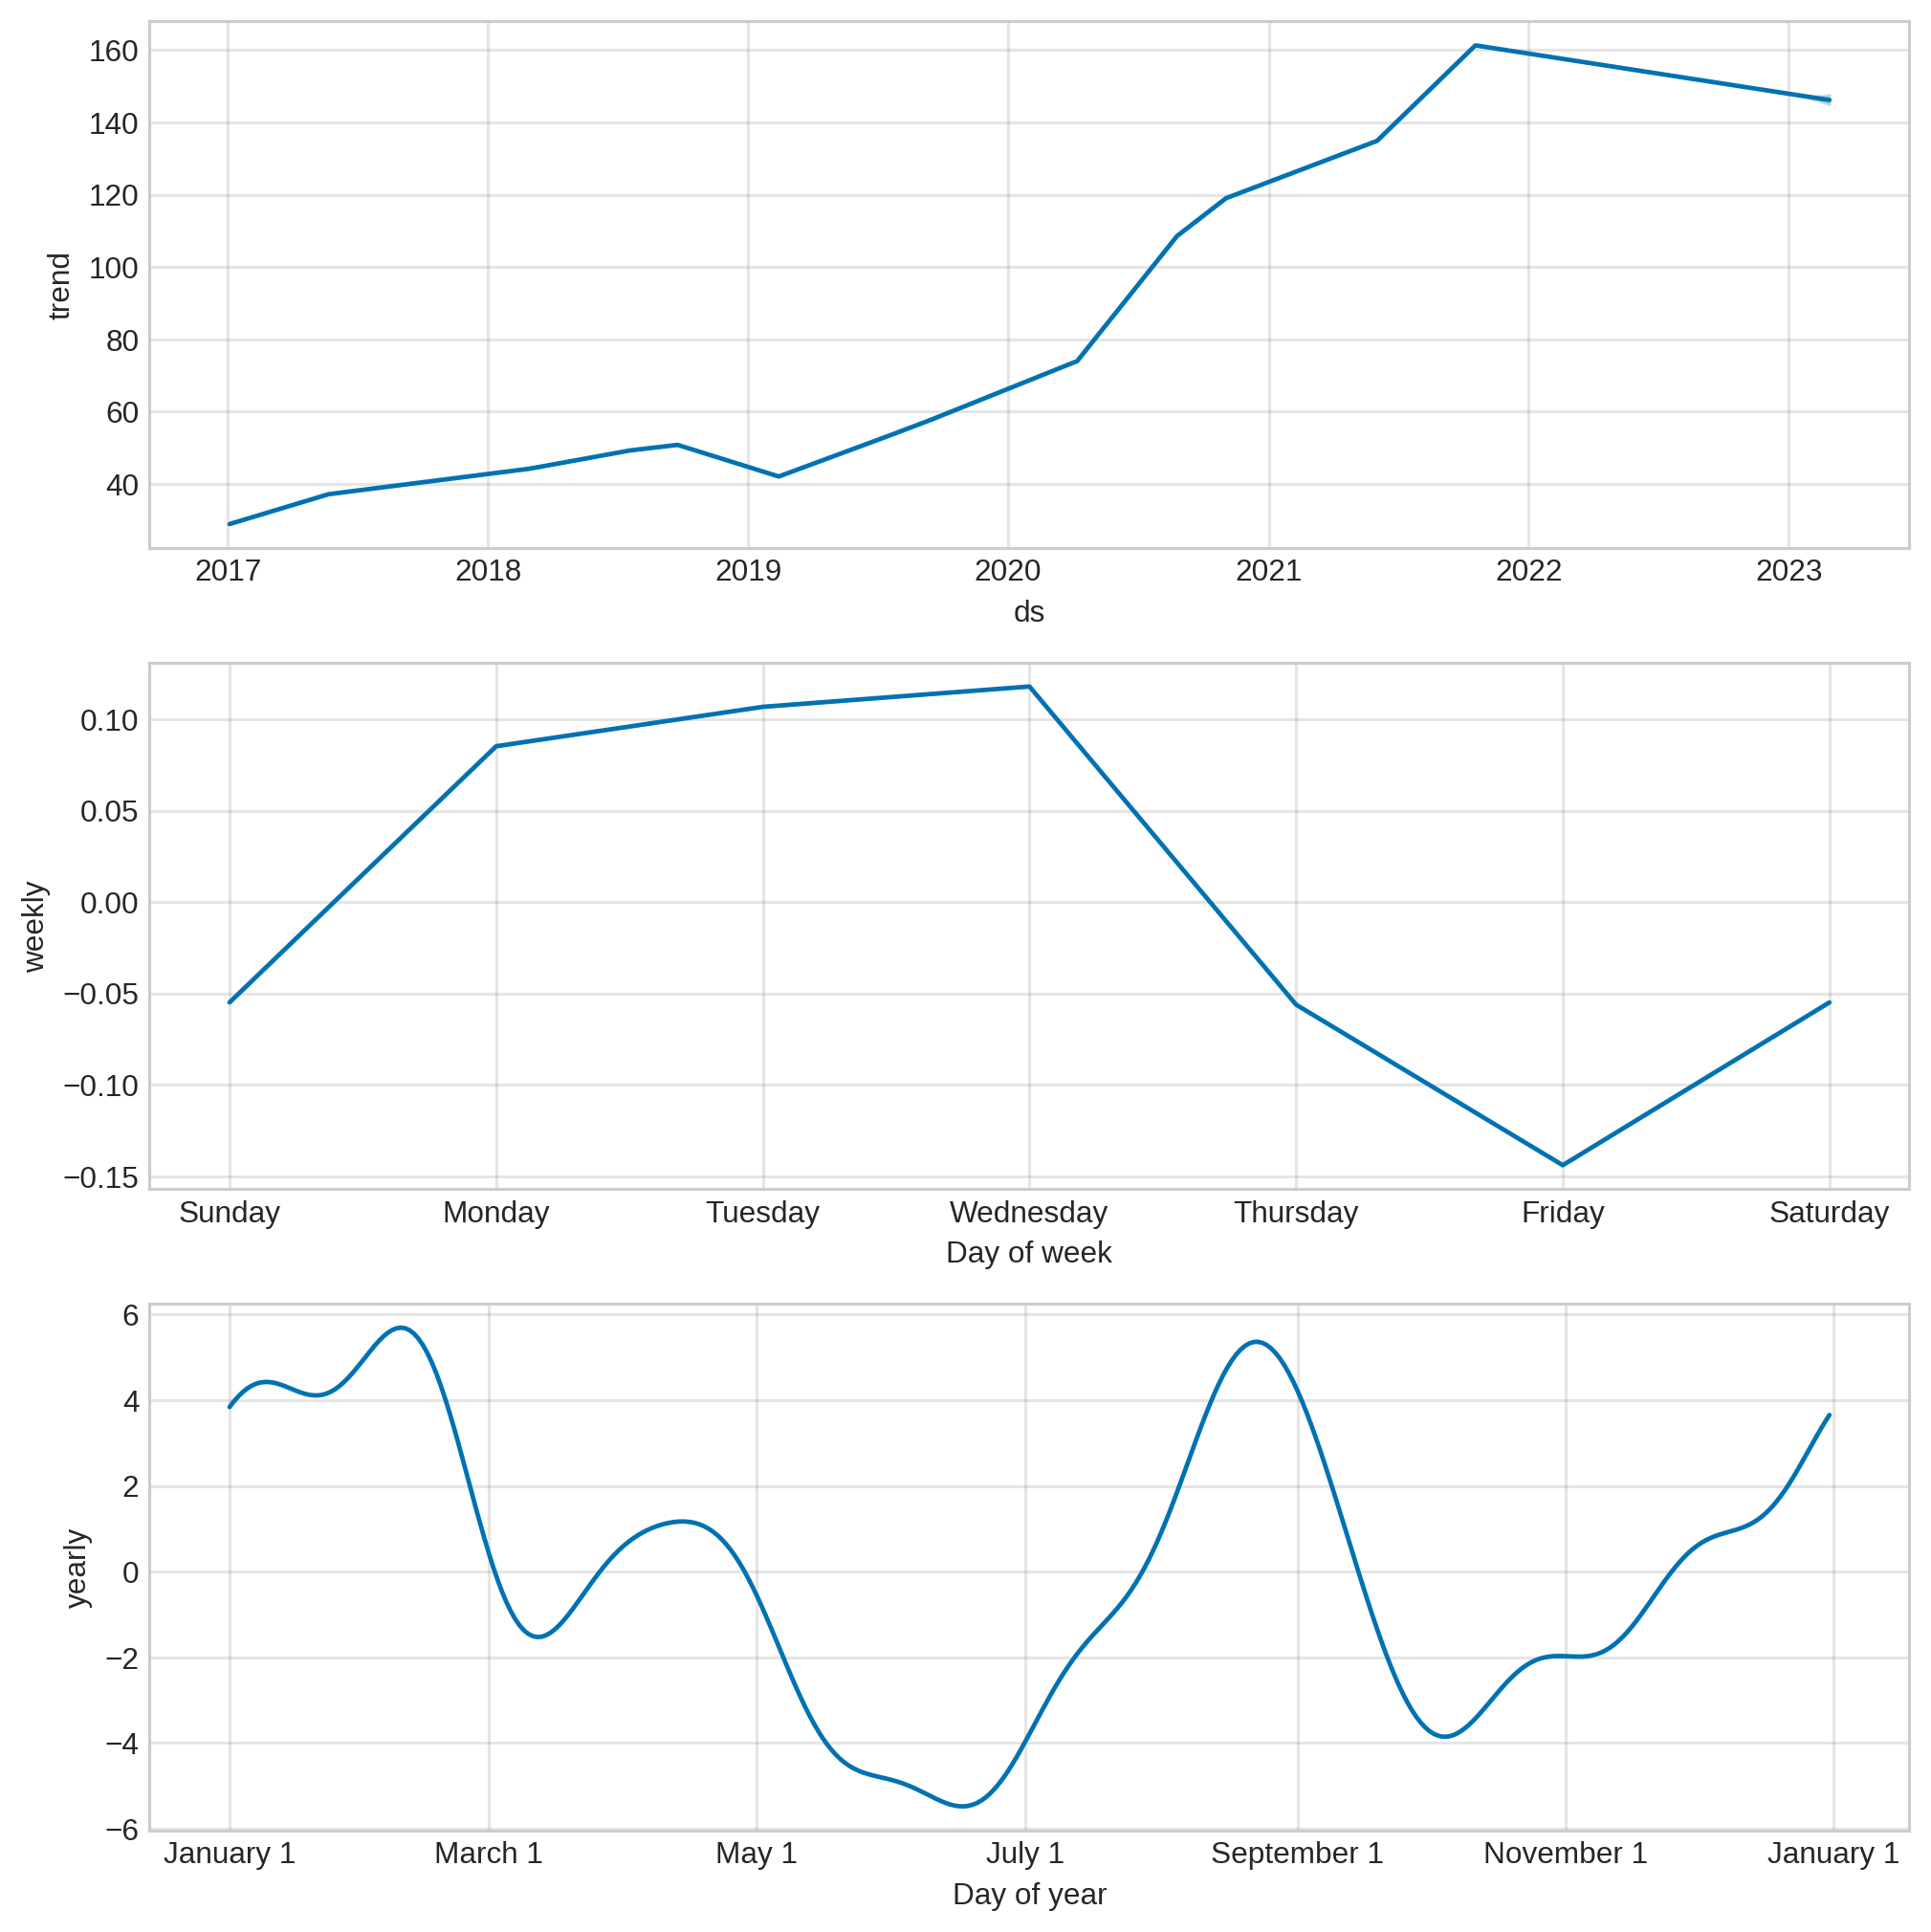

In [31]:
figure_comp1 = model1.plot_components(pred1)

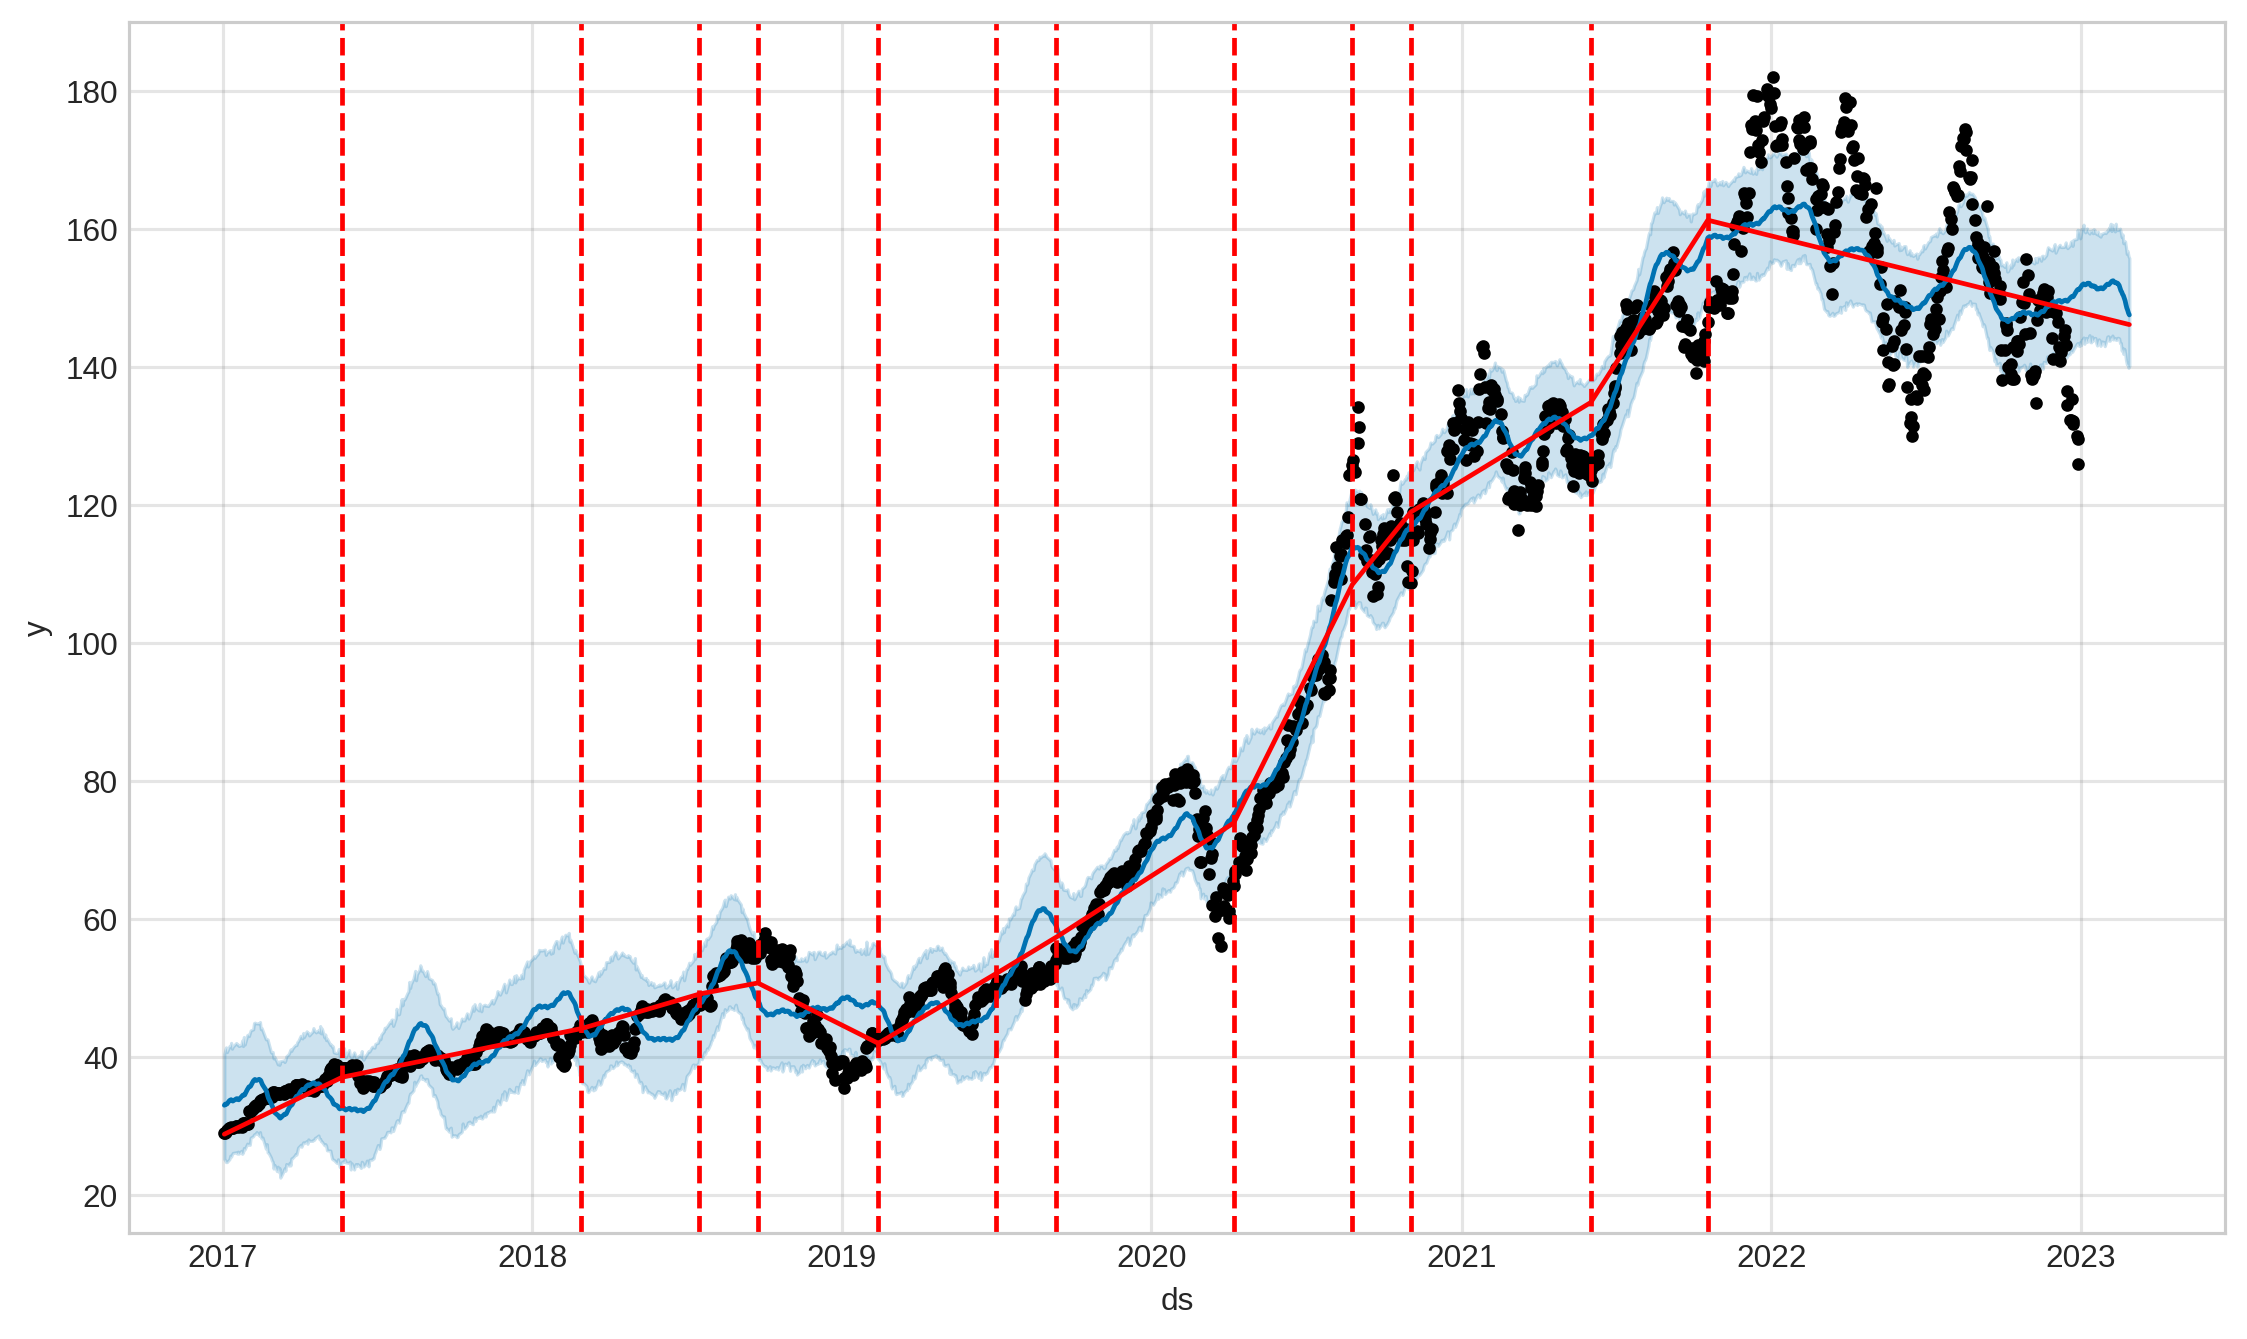

In [32]:
plot_model1 = model1.plot(pred1)
a1 = add_changepoints_to_plot(plot_model1.gca(), model1, pred1)

In [33]:
model.changepoints

48     2017-03-14
96     2017-05-22
145    2017-08-01
193    2017-10-09
241    2017-12-15
289    2018-02-27
338    2018-05-08
386    2018-07-17
434    2018-09-24
482    2018-11-30
531    2019-02-13
579    2019-04-24
627    2019-07-02
675    2019-09-10
724    2019-11-18
772    2020-01-29
820    2020-04-07
868    2020-06-16
917    2020-08-25
965    2020-11-02
1013   2021-01-12
1061   2021-03-23
1110   2021-06-02
1158   2021-08-10
1206   2021-10-18
Name: ds, dtype: datetime64[ns]

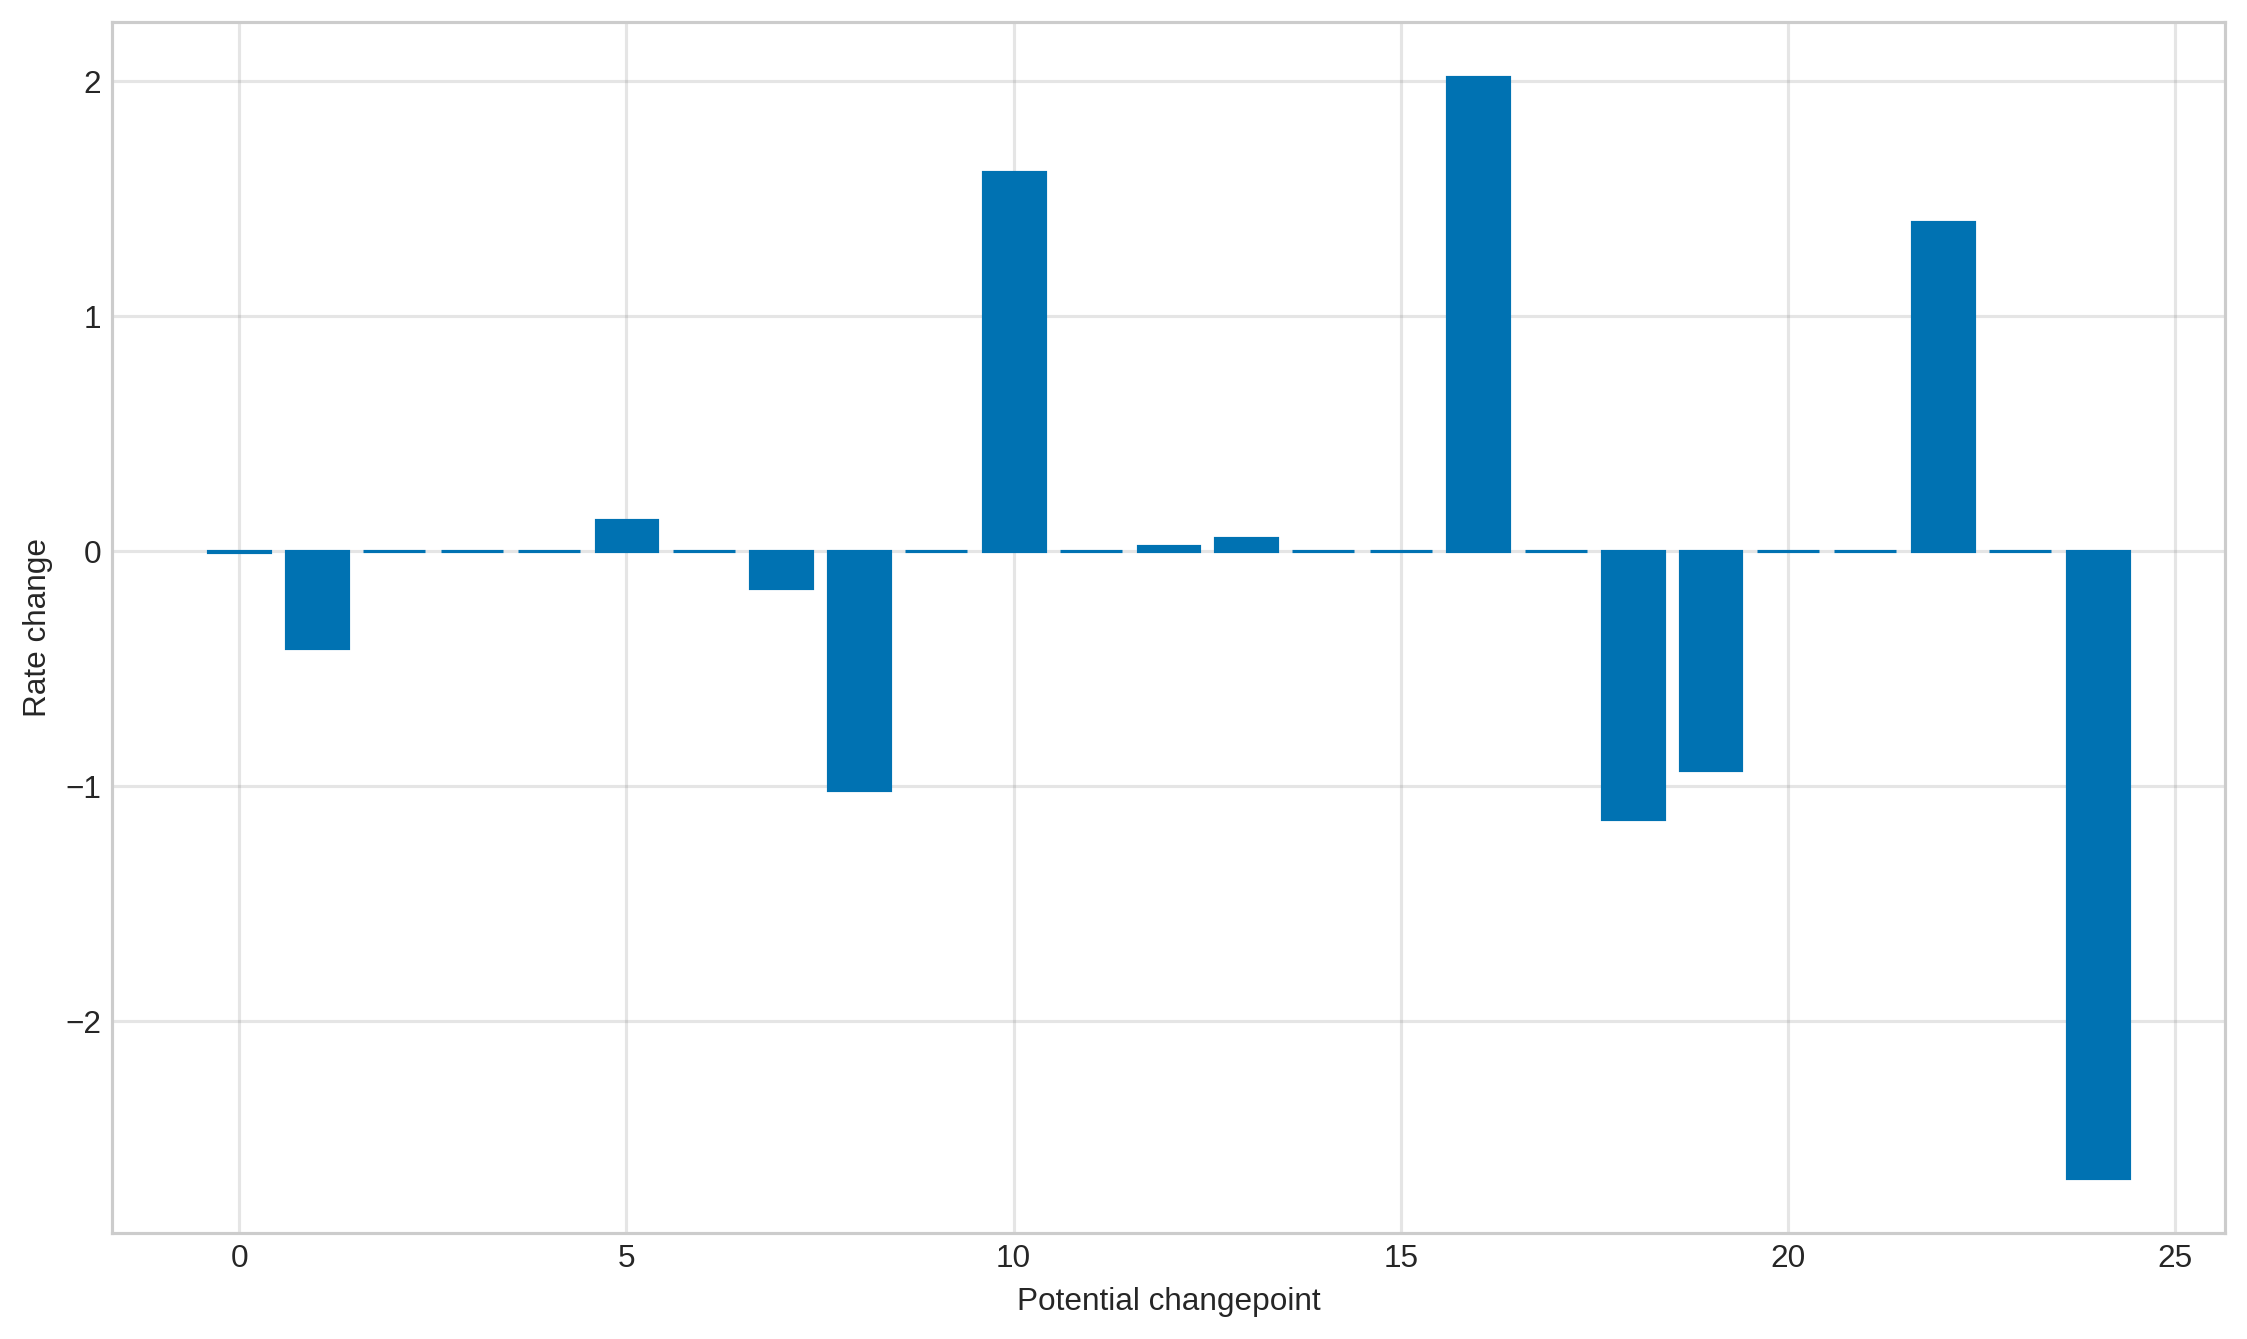

In [34]:
deltas = model1.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq6xr3mav/ktnmks8_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq6xr3mav/0n5gw_j9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28612', 'data', 'file=/tmp/tmpq6xr3mav/ktnmks8_.json', 'init=/tmp/tmpq6xr3mav/0n5gw_j9.json', 'output', 'file=/tmp/tmpq6xr3mav/prophet_modelfyg5jv5i/prophet_model-20240424214546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:45:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:45:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


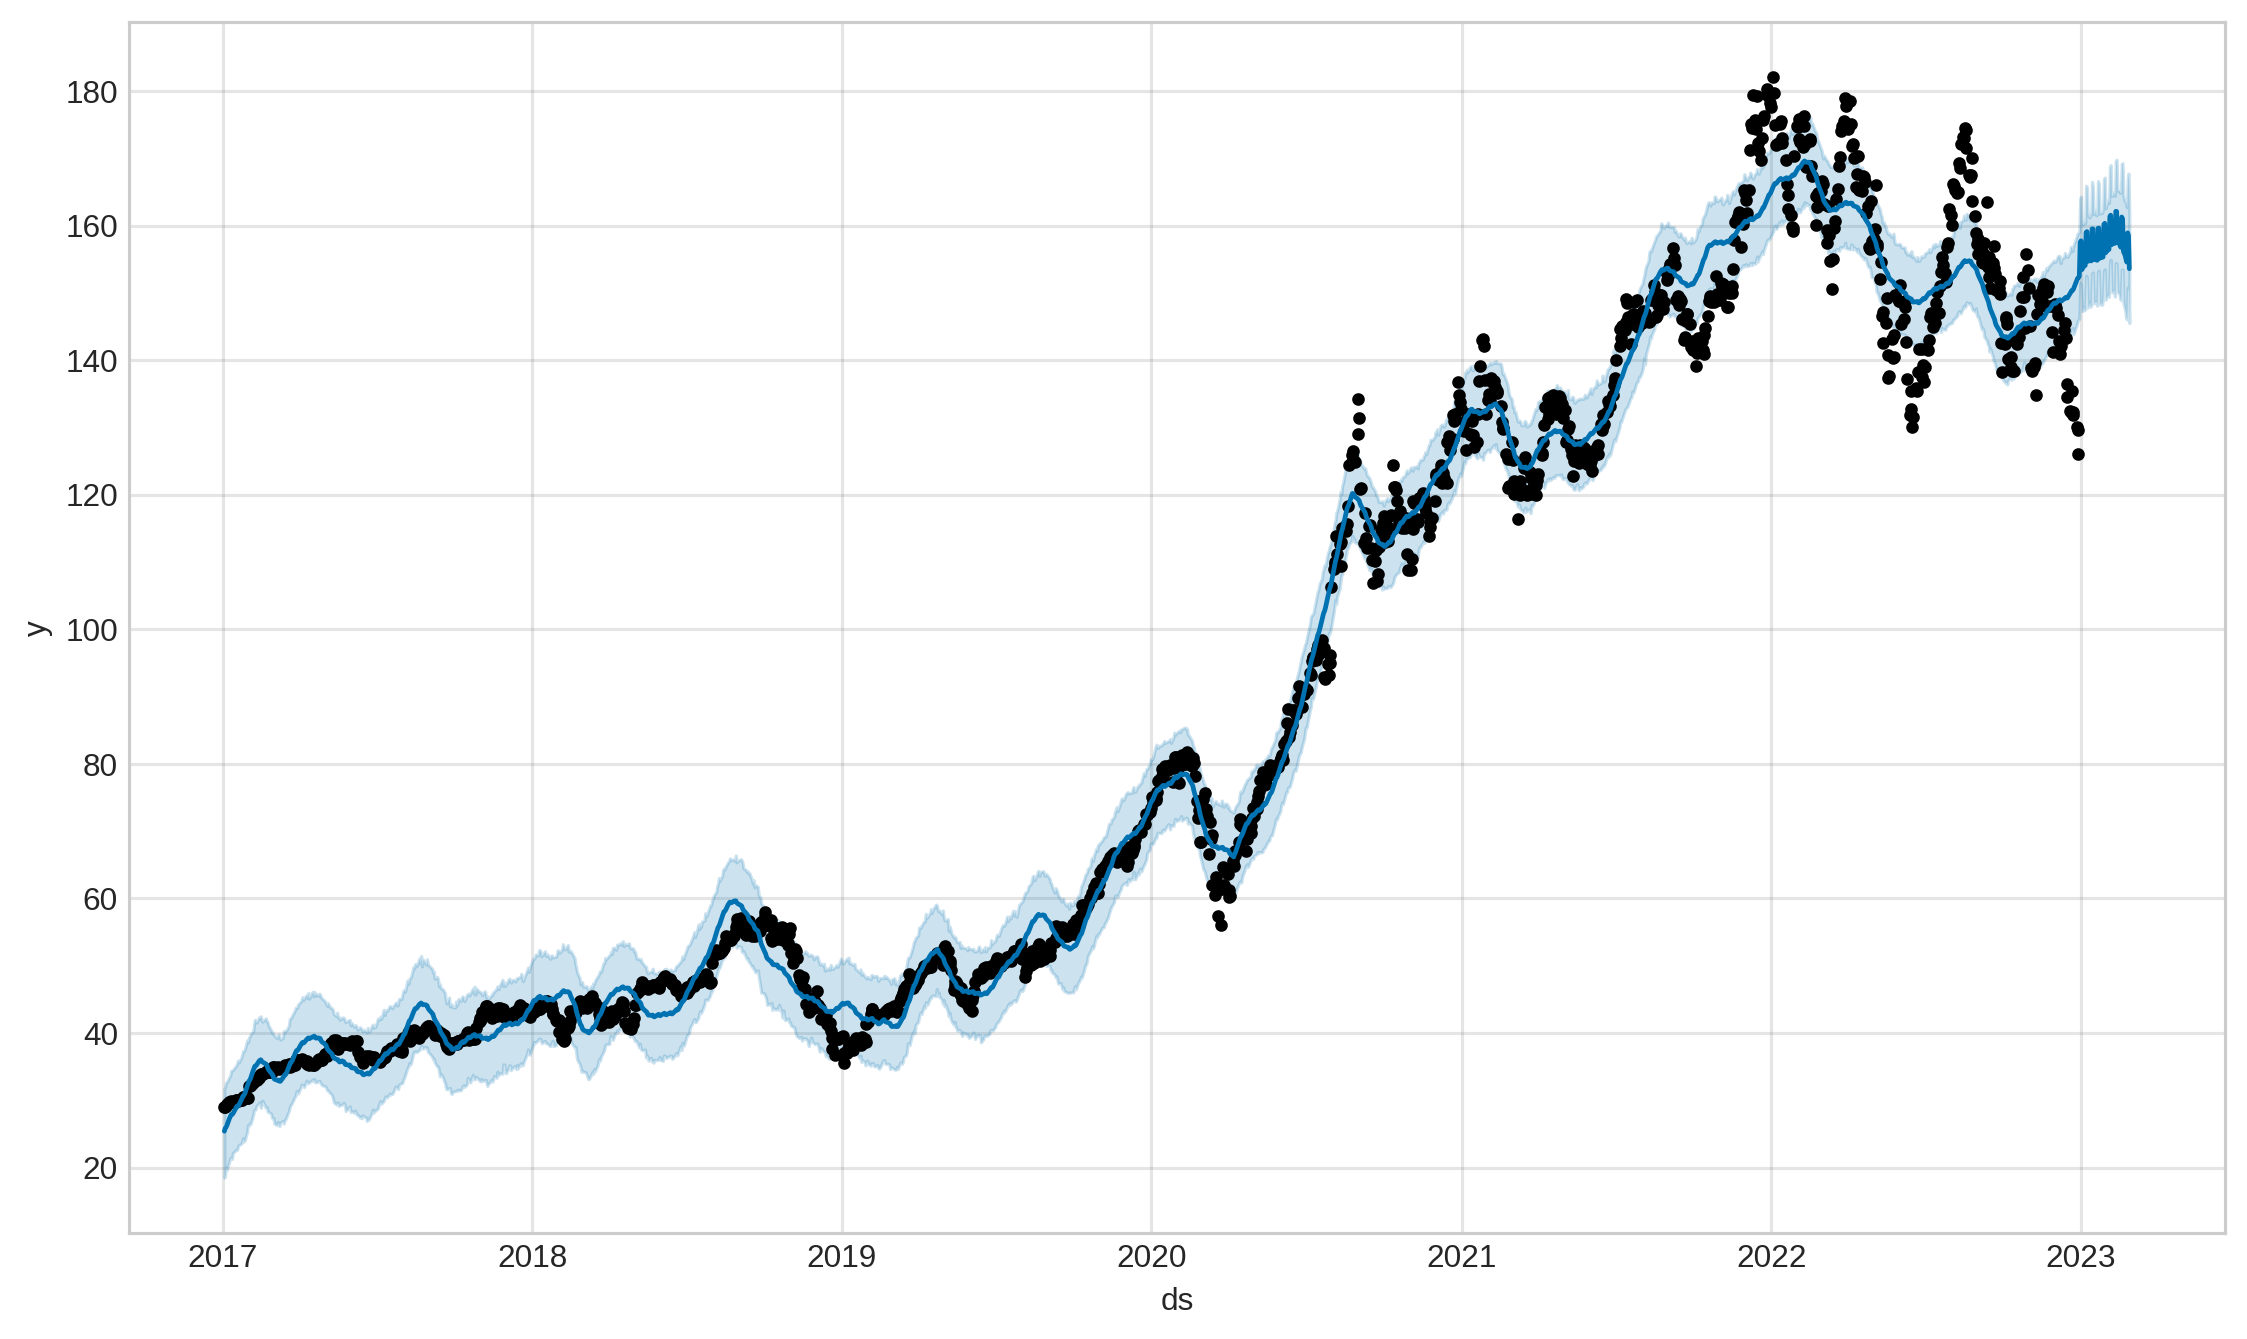

In [35]:
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(Closedf).predict(future1)
Newfig = m.plot(forecast)

In [36]:
df_cv1 = cross_validation(model1, initial='730 days', period='180 days', horizon='365 days')
df_p1 = performance_metrics(df_cv1)

print("Mean Absolute Error (MAE):", df_p1['mae'].values[0])
print("Root Mean Squared Error (RMSE):", df_p1['rmse'].values[0])

INFO:prophet:Making 7 forecasts with cutoffs between 2019-01-14 00:00:00 and 2021-12-29 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpq6xr3mav/qvuk3z2t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq6xr3mav/b49w951d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75270', 'data', 'file=/tmp/tmpq6xr3mav/qvuk3z2t.json', 'init=/tmp/tmpq6xr3mav/b49w951d.json', 'output', 'file=/tmp/tmpq6xr3mav/prophet_modelm2ss76vp/prophet_model-20240424214550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:45:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:45:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq6xr3mav/kp4fw4hx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq6xr3mav/gs9a6uib.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Mean Absolute Error (MAE): 6.810819364708164
Root Mean Squared Error (RMSE): 8.877928229252413


In [37]:
df_cv1.head(5)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-15,37.715598,36.580534,38.907351,38.267502,2019-01-14
1,2019-01-16,37.727878,36.502030,38.945838,38.735001,2019-01-14
2,2019-01-17,37.651997,36.416470,38.853655,38.965000,2019-01-14
3,2019-01-18,37.525684,36.337556,38.791370,39.205002,2019-01-14
4,2019-01-22,37.240708,36.047146,38.524365,38.325001,2019-01-14


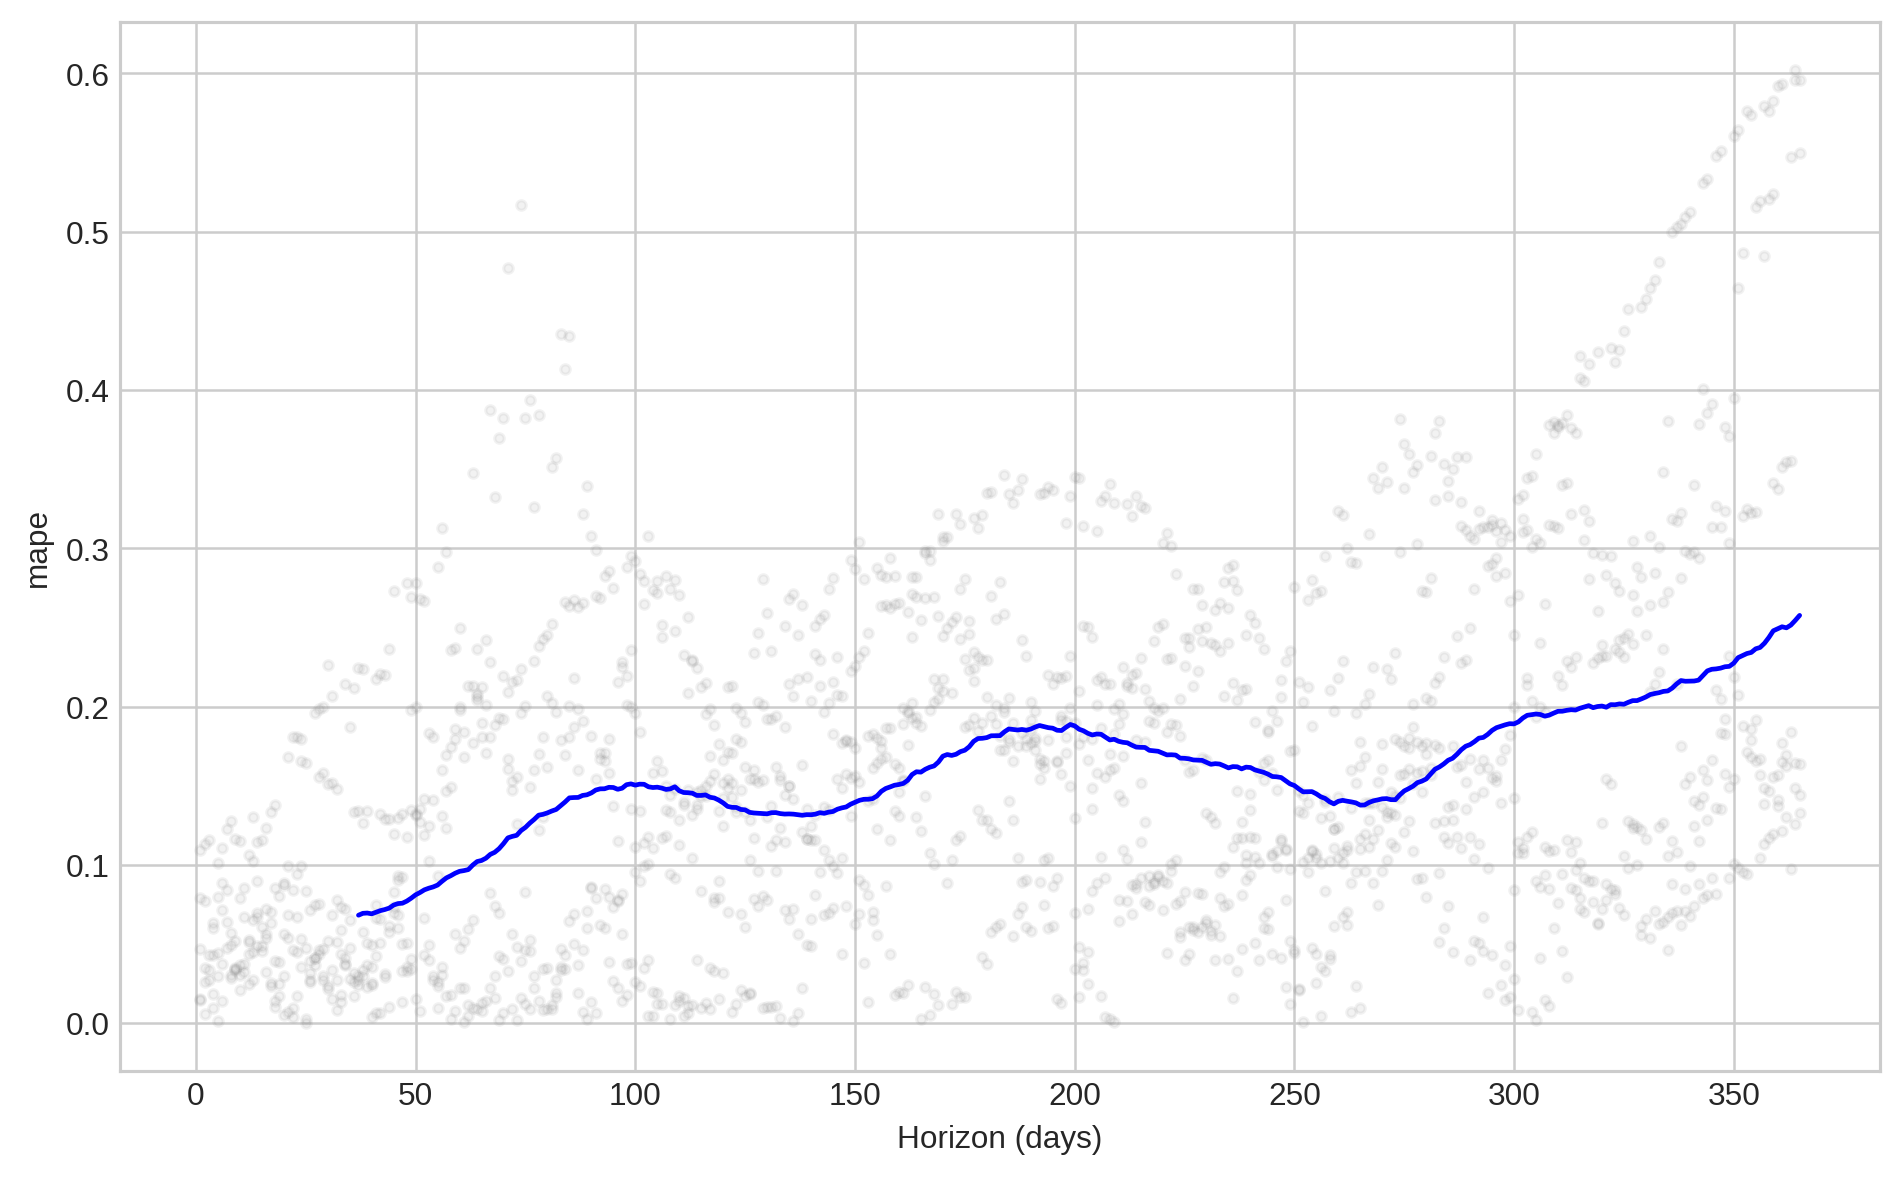

In [38]:
CV_fig1 = plot_cross_validation_metric(df_cv1, metric='mape')

In [39]:
df_p1.head(5)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,78.817610,8.877928,6.810819,0.068222,0.051281,0.071938,0.277273
1,38 days,81.464051,9.025744,6.904183,0.069415,0.051584,0.073282,0.271591
2,39 days,80.960460,8.997803,6.895437,0.069593,0.051281,0.073472,0.269886
3,40 days,80.692894,8.982922,6.883111,0.069094,0.050893,0.072939,0.277273
4,41 days,83.277724,9.125663,6.988429,0.070100,0.051281,0.074053,0.271591
